National Average Enrollment Rate vs VDOE Program Average Enrollment Rate

- t-test, p-value, and confidence interval
- 95% confidence level

- 'fafsa_submitted_rate': Proxy variable for college enrollment rate

- 'enrolled_rate': enrollment rate

- 'institutional_aid_total_dollars_rate': (per student): funding effect
- 'specific_interactions_1-on-1s_total_rate': (per student): counselor effect
- 'college_waivers_total_#_waivers_rate'
- 'act_sats_completed_rate': (per student): test taking effect
- 'college_awareness_college_fairs_at_least_one_rate': (per student): awareness effect

controls:
- 'total_male_rate'
- 'total_white_rate'
- 'total_black_rate'
- 'econ_total_rate'
- 'student_totals_seniors': Total students, perhaps the school size may have an effect on the 
- 'school_name': categorical variable capture fixed effects x 23
- 'year_starting': categorical variable to capture yearly temporal fixed effects x 6

statistical significance of total_black_rate, coefficient magnitude interpretation, and sign  
statistical significance of total_white_rate, coefficient magnitude interpretation, and sign 

statistical significance of specific_interactions_1-on-1s_total_rate, coefficient magnitude interpretation, and sign

Other Unknown 

by school is the enrollment rate different than the rest of the population?

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('cleaned_combined_2015_2020.csv')

In [54]:
# display df.columns in a dataframe
cols = df.columns
# display max rows
pd.set_option('display.max_rows', None)
# display col width to 100
pd.set_option('display.max_colwidth', 100)
cols_df = pd.DataFrame({'Variable_Names': cols})
cols_df

,Variable_Names
0,student_totals_seniors
1,specific_interactions_1-on-1s_total
2,specific_interactions_group_total
3,specific_interactions_1-on-1s_at_least_one
4,specific_interactions_group_at_least_one
5,specific_interactions_parent_meetings
6,specific_interactions_parent_meetings_at_least_one
7,total_interactions_met_with_1_plus_times_(group_and_1_1)
8,total_interactions_met_with_3_plus_times_(group_and_1_1)
9,total_interactions_met_with_5_plus_times_(group_and_1_1)


In [55]:
# Separate the variable to exclude response variable defining
y = df['enrolled_rate']

# adhoc
exploration_vars = ['institutional_aid_total_dollars_rate', 'specific_interactions_1-on-1s_total_rate', 'act_sats_completed_rate', 'college_awareness_college_fairs_at_least_one_rate']
kpi_vars = ['specific_interactions_1-on-1s_total_rate', 
            'specific_interactions_group_total_rate', 
            'specific_interactions_1-on-1s_at_least_one_rate', 
            'specific_interactions_group_at_least_one_rate', 
            'specific_interactions_parent_meetings_rate', 
            'specific_interactions_parent_meetings_at_least_one_rate', 
            'total_interactions_met_with_1_plus_times_(group_and_1_1)_rate', 
            'total_interactions_met_with_3_plus_times_(group_and_1_1)_rate', 
            'total_interactions_met_with_5_plus_times_(group_and_1_1)_rate', 
            'total_interactions_met_with_10_plus_times_(group_and_1_1)_rate']

# preprocessing
#df = df.drop(['school_name', 'year_starting'], axis=1)
df = pd.get_dummies(df, columns=['school_name', 'year_starting'])
df['gender_enrolled_ratio_f_m'] = df['enrolled_female_rate'] / df['enrolled_male_rate']
df['race_enrolled_ratio_w_b'] = df['enrolled_white_rate'] / df['enrolled_black_rate']
df['race_population_ratio_w_b'] = df['total_white_rate'] / df['total_black_rate']

# drop 'completeness' variables
x = df.drop(['enrolled_rate', 'enrolled_female_rate', 'enrolled_male_rate', 'enrolled_white_rate', 'enrolled_black_rate', 'total_black_rate', 'total_white_rate', 'total_female_rate', 'econ_enrolled_rate'], axis=1)
x = x[x.columns[pd.Series(x.columns).str.startswith('school_name') | pd.Series(x.columns).str.startswith('year_starting') | pd.Series(x.columns).str.endswith('rate')]]

We prepare the data for use in a regression model by creating dummy variables for the categorical variables. We seperate the enrolled rate from the other variables to use as the response variable. Because enrolled_female_rate and enrolled_male_rate total to the complete population we include a ratio variable. We apply a similar technique for the race demographics we have available from the VDOE data, generating a ratio of one variable to the total population. We initially explored without including categorical variables for the schools and years, which resulted in no significance found via lasso regression. We then included the dummy variables for school_name and year_starting.

In [56]:
# Standardize the predictors
X_scaled = StandardScaler().fit_transform(x)

X = X_scaled

All predictors are placed on a common scale to ensure that the model is not dominated by any one variable based on the scale of the data. This ensures that the Lasso Regression selects predictors based on their relationship with the response variable, not their scale.

In [57]:
param_grid = {'alpha': np.logspace(-3, 3, 100)}

lasso_grid_search = GridSearchCV(Lasso(), param_grid, cv=5) 
lasso_grid_search.fit(X, y)
best_lasso_alpha = lasso_grid_search.best_params_['alpha']

lasso_model = Lasso(alpha=best_lasso_alpha)
lasso_model.fit(X, y)

# # ridge regression
# ridge_grid_search = GridSearchCV(Ridge(), param_grid, cv=5)
# ridge_grid_search.fit(X, y)
# best_ridge_alpha = ridge_grid_search.best_params_['alpha']

# ridge_model = Ridge(alpha=best_ridge_alpha)
# ridge_model.fit(X, y)
# lasso_model = ridge_model

Lasso(alpha=0.0030538555088334154)

Lasso Regression is a type of linear regression that encourage variable reduction by penalizing the size of coefficients. This L1 regularization penalty encourages the model to select only the most important predictors, and set the coefficients of the others to zero. This is useful when we have many predictors, and we want to select only the most important ones. This can help overfitting and help narrow down what predictors are most important.

In [58]:
model_results = pd.DataFrame({'var_name': x.columns,
                          'lasso_coefficient': lasso_model.coef_})
model_results[model_results['lasso_coefficient'] != 0].sort_values(ascending = False,by='lasso_coefficient')

,var_name,lasso_coefficient
52,school_name_Charlottesville High School,0.019463
48,school_name_Alexandria City High School,0.018594
50,school_name_Bassett High School,0.018307
53,school_name_Chatham High School (Virginia),0.012515
61,school_name_Magna Vista High School,0.011409
62,school_name_Martinsville High School,0.009899
71,year_starting_2015.0,0.008255
68,school_name_Tunstall High School,0.006653
74,year_starting_2018.0,0.006544
31,college_apps_accepted_1_plus_apps_rate,0.006533


In [59]:
from sklearn.utils import resample
from sklearn.linear_model import Lasso

# Assume X and y are your features and target variable
n_bootstrap = 1000
bootstrap_coefs = []

lasso_model = Lasso(alpha=best_lasso_alpha)

for _ in range(n_bootstrap):
    X_resample, y_resample = resample(X, y)
    lasso_model.fit(X_resample, y_resample)
    bootstrap_coefs.append(lasso_model.coef_)

bootstrap_coefs = np.array(bootstrap_coefs)

In [60]:
# Calculate the 95% confidence intervals
conf_int = np.percentile(bootstrap_coefs, [2.5, 97.5], axis=0)

conf_int_df = pd.DataFrame({'var_name': x.columns,
                            'lower_bound': conf_int[0],
                            'upper_bound': conf_int[1]})
conf_int_df['coef'] = lasso_model.coef_
conf_int_df['significant'] = (conf_int_df['lower_bound'] > 0) | (conf_int_df['upper_bound'] < 0)
conf_int_df['impact']= lasso_model.coef_ * y.std()
conf_int_df['lower_impact'] = conf_int_df['lower_bound'] * y.std()
conf_int_df['upper_impact'] = conf_int_df['upper_bound'] * y.std()
display(conf_int_df[conf_int_df['significant']])

sig_conf_int_df = conf_int_df[conf_int_df['significant']]

,var_name,lower_bound,upper_bound,coef,significant,impact,lower_impact,upper_impact
48,school_name_Alexandria City High School,0.004467,0.025167,0.024987,True,0.002441,0.000436,0.002459
49,school_name_Armstrong High School,-0.047302,-0.007571,-0.025843,True,-0.002525,-0.004621,-0.000740
52,school_name_Charlottesville High School,0.007947,0.025455,0.022807,True,0.002228,0.000776,0.002487
58,school_name_Huguenot High School,-0.027797,-0.003460,-0.015951,True,-0.001558,-0.002716,-0.000338
61,school_name_Magna Vista High School,0.000293,0.016608,0.013401,True,0.001309,0.000029,0.001623
69,school_name_Washington and Lee High School,-0.029750,-0.006180,-0.021419,True,-0.002093,-0.002907,-0.000604
76,year_starting_2020.0,-0.030253,-0.009488,-0.010762,True,-0.001051,-0.002956,-0.000927


/var/folders/zx/rrsnqrlj32d4zdyzdhfp0xhh0000gn/T/ipykernel_14016/104220751.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_conf_int_df['impact_centered'] = sig_conf_int_df['impact'] - sig_conf_int_df['impact'].mean()
/var/folders/zx/rrsnqrlj32d4zdyzdhfp0xhh0000gn/T/ipykernel_14016/104220751.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sig_conf_int_df['error'] = sig_conf_int_df[['impact', 'lower_impact', 'upper_impact']].apply(lambda x: max(abs(x[0]-x[1]), abs(x[0]-x[2])), axis=1)
/var/folders/zx/rrsnqrlj32d4zdyzdhfp0xhh0000gn/T/ipykernel_14016/1

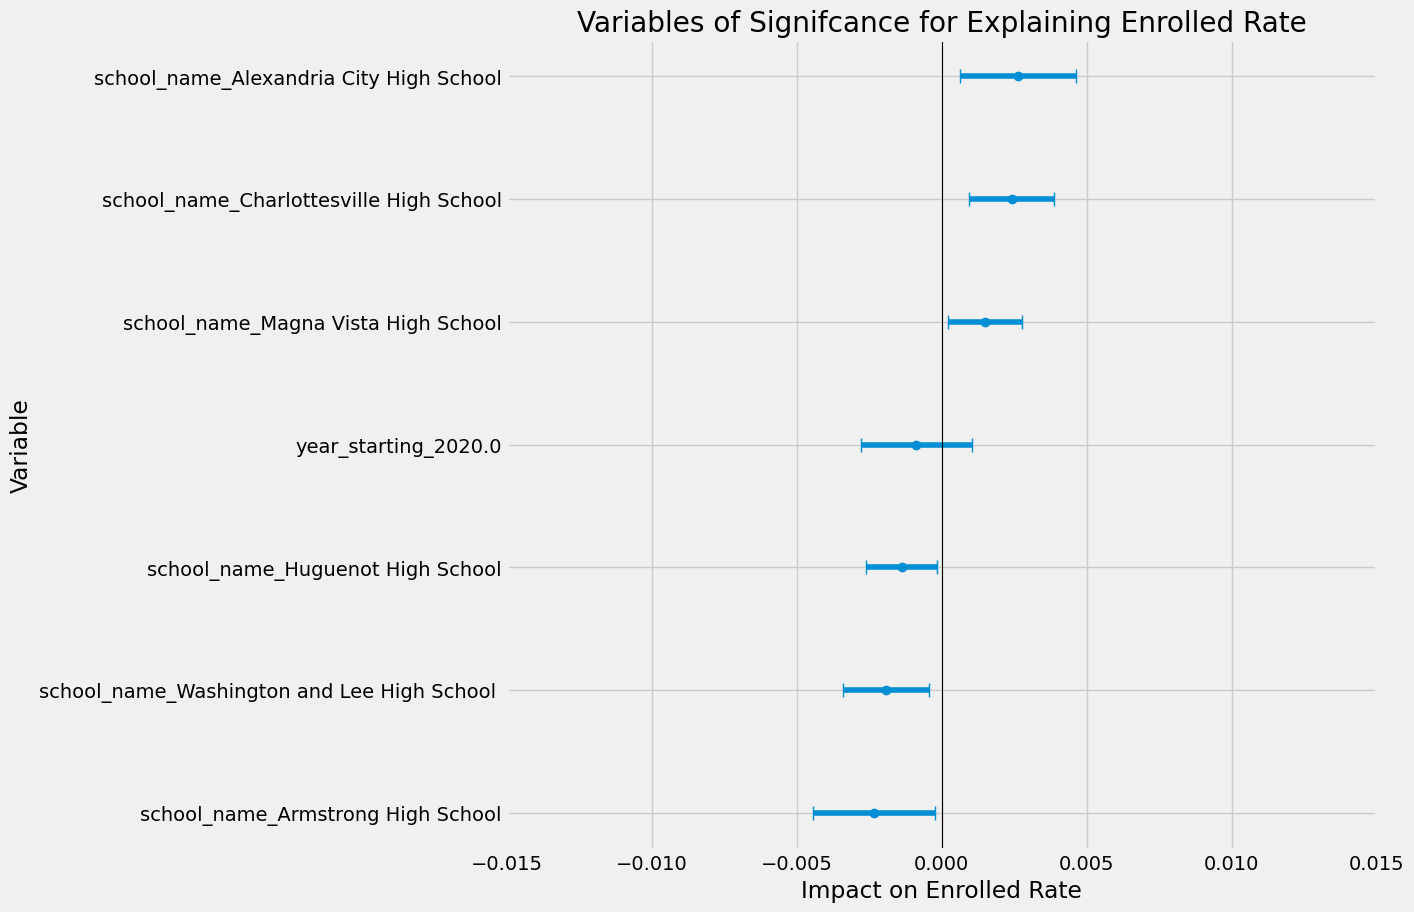

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use('fivethirtyeight')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Center the 'impact' values at 0
sig_conf_int_df['impact_centered'] = sig_conf_int_df['impact'] - sig_conf_int_df['impact'].mean()

# Calculate the symmetric error values
sig_conf_int_df['error'] = sig_conf_int_df[['impact', 'lower_impact', 'upper_impact']].apply(lambda x: max(abs(x[0]-x[1]), abs(x[0]-x[2])), axis=1)

# filter to only significant coefficients
#conf_int_df = conf_int_df[conf_int_df['significant']]
# select only variables in the kpi 
sig_conf_int_df = sig_conf_int_df.sort_values('impact_centered')

# Plot the coefficients with error bars
ax.errorbar(sig_conf_int_df['impact_centered'], sig_conf_int_df['var_name'], xerr=sig_conf_int_df['error'], fmt='o', capsize=5)

# Set the title and labels
ax.set_title('Variables of Signifcance for Explaining Enrolled Rate')
ax.set_ylabel('Variable')
ax.set_xlabel('Impact on Enrolled Rate')

# Add a vertical line at 0
ax.axvline(0, color='black', linewidth=0.8)

# fixed scale at .15
ax.set_xlim(-0.015, 0.015)

# Show the plot
plt.show()

In [62]:
display(sig_conf_int_df)

,var_name,lower_bound,upper_bound,coef,significant,impact,lower_impact,upper_impact,impact_centered,error
49,school_name_Armstrong High School,-0.047302,-0.007571,-0.025843,True,-0.002525,-0.004621,-0.000740,-0.002346,0.002097
69,school_name_Washington and Lee High School,-0.029750,-0.006180,-0.021419,True,-0.002093,-0.002907,-0.000604,-0.001914,0.001489
58,school_name_Huguenot High School,-0.027797,-0.003460,-0.015951,True,-0.001558,-0.002716,-0.000338,-0.001380,0.001220
76,year_starting_2020.0,-0.030253,-0.009488,-0.010762,True,-0.001051,-0.002956,-0.000927,-0.000873,0.001904
61,school_name_Magna Vista High School,0.000293,0.016608,0.013401,True,0.001309,0.000029,0.001623,0.001488,0.001281
52,school_name_Charlottesville High School,0.007947,0.025455,0.022807,True,0.002228,0.000776,0.002487,0.002407,0.001452
48,school_name_Alexandria City High School,0.004467,0.025167,0.024987,True,0.002441,0.000436,0.002459,0.002620,0.002005


/var/folders/zx/rrsnqrlj32d4zdyzdhfp0xhh0000gn/T/ipykernel_14016/3198461046.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  conf_int_df['error'] = conf_int_df[['impact', 'lower_impact', 'upper_impact']].apply(lambda x: max(abs(x[0]-x[1]), abs(x[0]-x[2])), axis=1)


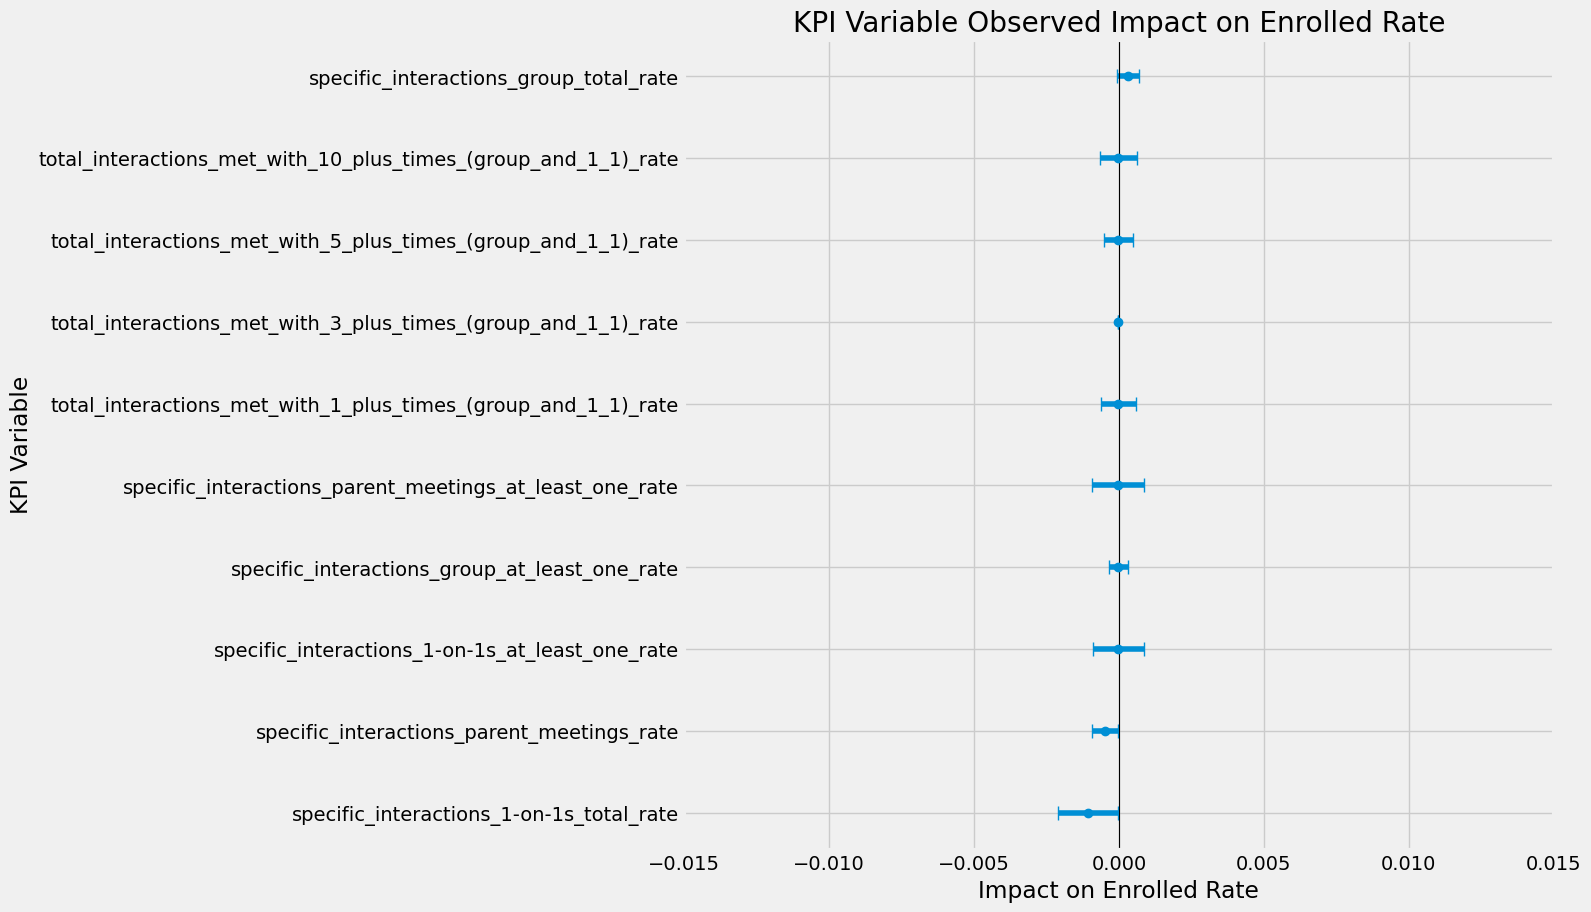

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use('fivethirtyeight')

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 10))

# Center the 'impact' values at 0
conf_int_df['impact_centered'] = conf_int_df['impact'] - conf_int_df['impact'].mean()

# Calculate the symmetric error values
conf_int_df['error'] = conf_int_df[['impact', 'lower_impact', 'upper_impact']].apply(lambda x: max(abs(x[0]-x[1]), abs(x[0]-x[2])), axis=1)

# filter to only significant coefficients
#conf_int_df = conf_int_df[conf_int_df['significant']]
# select only variables in the kpi 
conf_int_df = conf_int_df[conf_int_df['var_name'].isin(kpi_vars)]
conf_int_df = conf_int_df.sort_values('impact_centered')

# Plot the coefficients with error bars
ax.errorbar(conf_int_df['impact_centered'], conf_int_df['var_name'], xerr=conf_int_df['error'], fmt='o', capsize=5)

# Set the title and labels
ax.set_title('KPI Variable Observed Impact on Enrolled Rate')
ax.set_ylabel('KPI Variable')
ax.set_xlabel('Impact on Enrolled Rate')

# Add a vertical line at 0
ax.axvline(0, color='black', linewidth=0.8)

# fixed scale at .15
ax.set_xlim(-0.015, 0.015)

# Show the plot
plt.show()

In [64]:
display(conf_int_df)

,var_name,lower_bound,upper_bound,coef,significant,impact,lower_impact,upper_impact,impact_centered,error
0,specific_interactions_1-on-1s_total_rate,-0.008118,0.000000,-0.010649,False,-0.001040,-0.000793,0.000000,-0.001058,0.001040
4,specific_interactions_parent_meetings_rate,-0.006677,0.000000,-0.004676,False,-0.000457,-0.000652,0.000000,-0.000475,0.000457
2,specific_interactions_1-on-1s_at_least_one_rate,-0.009108,0.000000,-0.000053,False,-0.000005,-0.000890,0.000000,-0.000023,0.000885
3,specific_interactions_group_at_least_one_rate,-0.003260,0.001845,0.000000,False,0.000000,-0.000318,0.000180,-0.000018,0.000318
5,specific_interactions_parent_meetings_at_least_one_rate,-0.009142,0.000000,-0.000000,False,-0.000000,-0.000893,0.000000,-0.000018,0.000893
6,total_interactions_met_with_1_plus_times_(group_and_1_1)_rate,-0.006236,0.000000,-0.000000,False,-0.000000,-0.000609,0.000000,-0.000018,0.000609
7,total_interactions_met_with_3_plus_times_(group_and_1_1)_rate,0.000000,0.000000,0.000000,False,0.000000,0.000000,0.000000,-0.000018,0.000000
8,total_interactions_met_with_5_plus_times_(group_and_1_1)_rate,0.000000,0.004977,0.000000,False,0.000000,0.000000,0.000486,-0.000018,0.000486
9,total_interactions_met_with_10_plus_times_(group_and_1_1)_rate,0.000000,0.006463,0.000000,False,0.000000,0.000000,0.000631,-0.000018,0.000631
1,specific_interactions_group_total_rate,0.000000,0.007420,0.003412,False,0.000333,0.000000,0.000725,0.000316,0.000392
